Muhammad Amirul Samsul Bahar, Universiti Malaya - WQD7005 Data Mining
# Forecasting WTI Crude Oil Price
------------------------------------
This notebook explains on forecasting WTI crude oil closing price using an artificial recurrent neural network namely Long Short Term Memory (LSTM).

In [1]:
# Import the libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### Step 1: Load the Data
---------------------------
<div align='justify'>
    
In this step, we will load the WTI price dataset as dataframe using pandas' `read_csv()` method and have a glimpse on how the data looks like. Some of the methods that we will be using a lot in the first few steps are:
* `DataFrame.info()`
* `DataFrame.head()`
* `DataFrame.tail()`

The data is scrapped from a website called <a href="https://markets.businessinsider.com/">Markets Insider</a>.

</div>

#### Read dataset from github as Pandas DataFrame

In [2]:
# Get the scrapped data from github:
github = 'https://raw.githubusercontent.com/muhdamirulsamsul/DataMining/master/wtiprice.csv'
df = pd.read_csv(github)

#### Print info of the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3614 entries, 0 to 3613
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3614 non-null   object 
 1   Closing Price  3614 non-null   float64
 2   Open           3554 non-null   float64
 3   Daily High     3595 non-null   float64
 4   Daily Low      3602 non-null   float64
dtypes: float64(4), object(1)
memory usage: 141.3+ KB


#### Have a glimpse on the dataset

In [4]:
df.head()

,Date,Closing Price,Open,Daily High,Daily Low
0,2020-03-11,32.98,34.62,36.35,32.56
1,2020-03-10,34.36,30.37,35.02,30.20
2,2020-03-09,31.13,32.87,34.88,27.34
3,2020-03-06,41.28,46.09,46.38,41.05
4,2020-03-05,45.90,47.13,47.57,45.65


In [5]:
df.tail()

,Date,Closing Price,Open,Daily High,Daily Low
3609,2006-02-09,62.62,62.68,63.73,62.38
3610,2006-02-08,62.55,62.96,63.44,62.29
3611,2006-02-07,63.09,64.82,64.90,62.81
3612,2006-02-06,65.11,66.35,66.50,64.77
3613,2006-02-03,65.37,64.77,65.48,63.93


### Step 2: Understanding and Cleaning the Data
---------------------------
<div align='justify'>
We will try to have a proper look on the column names, the data type of each column, and the index. The date starts from year 2006 to 2020. The dataframe needs to be sorted reversely since it starts from year 2020 as you can see from the above table. It is quite troublesome to have a long name for the column. Thus, we will shorten the column names. Then, we will observe the data type of each column and determine wether the data type is appropriate or not. Plot of the data will help us to understand more about the data. We can see the maximum and minimum value quickly just by looking at the plot. Once plotted, we will scale the data.
</div>

#### Sorting the data

In [6]:
# Sort index in descending order and then reset the index
df = df.sort_index(ascending=False).reset_index(drop=True)

In [7]:
df.head()

,Date,Closing Price,Open,Daily High,Daily Low
0,2006-02-03,65.37,64.77,65.48,63.93
1,2006-02-06,65.11,66.35,66.50,64.77
2,2006-02-07,63.09,64.82,64.90,62.81
3,2006-02-08,62.55,62.96,63.44,62.29
4,2006-02-09,62.62,62.68,63.73,62.38


In [8]:
df.tail()

,Date,Closing Price,Open,Daily High,Daily Low
3609,2020-03-05,45.90,47.13,47.57,45.65
3610,2020-03-06,41.28,46.09,46.38,41.05
3611,2020-03-09,31.13,32.87,34.88,27.34
3612,2020-03-10,34.36,30.37,35.02,30.20
3613,2020-03-11,32.98,34.62,36.35,32.56


#### Changing the column names

In [9]:
# Changing the column names
df.columns = ['Date', 'Close', 'Open', 'High', 'Low']
df.columns

Index(['Date', 'Close', 'Open', 'High', 'Low'], dtype='object')

#### Changing the datatype

In [10]:
# Change the data type for Date column
df['Date'] = pd.to_datetime(df['Date'])
# Making sure the data type is changed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3614 entries, 0 to 3613
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3614 non-null   datetime64[ns]
 1   Close   3614 non-null   float64       
 2   Open    3554 non-null   float64       
 3   High    3595 non-null   float64       
 4   Low     3602 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 141.3 KB


In [11]:
# For ease of work, the date becomes the index
df.set_index('Date', inplace=True)
df.head()

,Close,Open,High,Low
Date,,,,
2006-02-03,65.37,64.77,65.48,63.93
2006-02-06,65.11,66.35,66.50,64.77
2006-02-07,63.09,64.82,64.90,62.81
2006-02-08,62.55,62.96,63.44,62.29
2006-02-09,62.62,62.68,63.73,62.38


#### Removing unused columns/features

Our concern is only the closing price because we will be predicting WTI price solely based on the closing price. Thus, other columns will not be needed.

In [12]:
wti = df[['Close']].copy()
wti.head()

,Close
Date,
2006-02-03,65.37
2006-02-06,65.11
2006-02-07,63.09
2006-02-08,62.55
2006-02-09,62.62


In [13]:
wti.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3614 entries, 2006-02-03 to 2020-03-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3614 non-null   float64
dtypes: float64(1)
memory usage: 56.5 KB


#### Detecting missing values

The info above mentioned there are 3614 total entries of the dataset, and column `Close` has `3614` non-null values which means there is no missing value in the columns. For confirmation, we can simply run `DataFrame.isnull().sum()`.

In [14]:
wti.isnull().sum()

Close    0
dtype: int64

#### Scale the data

Now, let us see how the data looks like once plotted.

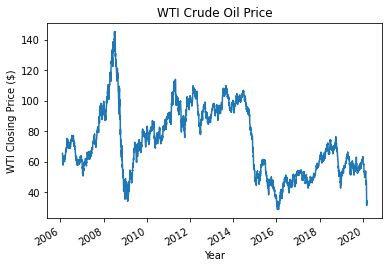

In [15]:
wti[['Close']].plot(legend=None)
plt.title('WTI Crude Oil Price')
plt.xlabel('Year')
plt.ylabel('WTI Closing Price ($)')
plt.show()

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_wti = scaler.fit_transform(wti)
scaled_wti

array([[0.31575342],
       [0.3135274 ],
       [0.29623288],
       ...,
       [0.02260274],
       [0.05025685],
       [0.03844178]])

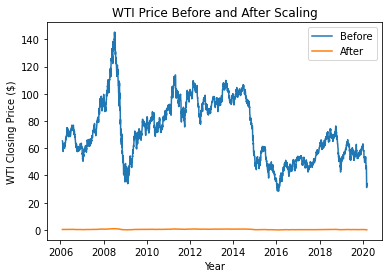

In [17]:
plt.plot(wti['Close'], label='Before')
plt.plot(wti.index,scaled_wti, label='After')
plt.legend()
plt.xlabel('Year')
plt.ylabel('WTI Closing Price ($)')
plt.title('WTI Price Before and After Scaling')
plt.show()

### Splitting the Dataset

We are now preparing the training dataset which will be used in our LSTM model. We will be splitting 80% training and 20% testing datasets.

In [18]:
train_len = math.ceil(len(scaled_wti)*.8)
train_len

2892

#### Creating the training dataset

In [19]:
train_data = [i[0] for i in scaled_wti[0:train_len]]

In [20]:
# 'n' is number of days to predict out to the future
n = 30

# Split into x_train and y_train datasets
x_train = []
y_train = []
for i in range(n,train_len):
    x_train.append(train_data[i-n:i])
    y_train.append(train_data[i])

# covert x_train and y_train into numpy
x_train, y_train = np.array(x_train), np.array(y_train)

# reshape the data - lstm expect 3-dimensional data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

#### Creating the testing dataset

In [ ]:
# Create the test data
# Create a new array containing scaled values from index
test_data = [i[0] for i in scaled_wti[train_len-n:]]

# Create the data sets x_test and y_test
x_test = []

# take the actual value of y
y_test = wti[train_len:]
for i in range(n, len(test_data)):
    x_test.append(test_data[i-n:i])

# convert to numpy array    
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Step 3: Building the LSTM Model
--------------------------------------------

In [22]:
model = Sequential()
# add lstm layer with 50 neuron
model.add(
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1))
)
model.add(
    LSTM(50, return_sequences=False)
)

# add dense layer with 25 neuron
model.add(Dense(25))

# add dense layer with i neuron
model.add(Dense(1))

#### Compiling the model
optimizer is used to improve the loss function,  and loss funtion is used to measure how the model did on training.

In [23]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2862/2862 [==============================] - 69s 24ms/step - loss: 0.0014
Epoch 2/10
2862/2862 [==============================] - 67s 23ms/step - loss: 5.2040e-04
Epoch 3/10
2862/2862 [==============================] - 67s 23ms/step - loss: 4.1719e-04
Epoch 4/10
2862/2862 [==============================] - 67s 24ms/step - loss: 4.0749e-04
Epoch 5/10
2862/2862 [==============================] - 68s 24ms/step - loss: 3.8182e-04
Epoch 6/10
2862/2862 [==============================] - 67s 24ms/step - loss: 3.6400e-04
Epoch 7/10
2862/2862 [==============================] - 75s 26ms/step - loss: 3.7530e-04
Epoch 8/10
2862/2862 [==============================] - 69s 24ms/step - loss: 3.4288e-04
Epoch 9/10
2862/2862 [==============================] - 68s 24ms/step - loss: 3.3963e-04
Epoch 10/10
2862/2862 [==============================] - 68s 24ms/step - loss: 3.2077e-04


#### Prediction using the trained model

In [27]:
# Predict price using the model
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#### Calculating the RMSE

In [47]:
rmse = np.sqrt(np.mean((predictions - y_test)**2))[0]
rmse

1.694434763928092

#### Plot the prediction

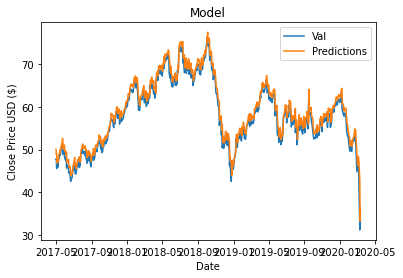

In [48]:
# plot the data
train = wti[:train_len].copy()
valid = wti[train_len:].copy()
valid['Predictions'] = predictions


plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train, label='train')
plt.plot(valid['Close'],label='Val')
plt.plot(valid['Predictions'],label='Predictions')
plt.legend()
plt.show()
